# EWMA - Exponentially Weighted Moving Averages

- Same thing as Exponential smoothing and a kind of low-pass filter

**Defined as:** At each step, the new moving average is the weighted sum of the new sample and the old moving average.

## EWMA in Code:

```py
xhat = df['GOOG'].ewm(alpha).mean()     # can substitute mean for var, cov, etc...
```

## Choosing Alpha

- Alpha is a decay factor
    - usually a small value between 0 and 1 (ie: 0.1, 0.2)
- Consider α = 1:
    - Copy the original time series
- Consider α = 0:
    - Copy itself
- Consider α = almost 1:
    - Follow new samples more than old samples
    - Expected to be a more jagged line
- Consider α = almost 0:
    - Follow existing average more
    - Expected to be a more smooth line



In [1]:
import pandas as pd
import numpy as np

In [2]:
# Using a non-financial dataset for this practice

df = pd.read_csv('../airline_passengers.csv', index_col='Month', parse_dates=True)
df.head()

,Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


In [3]:
df.isna().sum()

Passengers    0
dtype: int64

<AxesSubplot:xlabel='Month'>

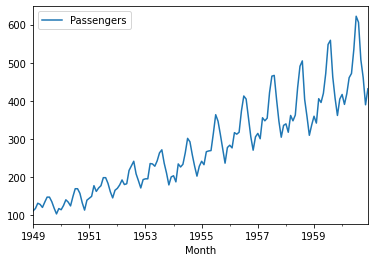

In [4]:
df.plot()

In [5]:
# Define Alpha - Can be adjusted for optimization

alpha = 0.2

In [6]:
# Calculate the EWMA

df['EWMA'] = df['Passengers'].ewm(alpha=alpha, adjust=False).mean()

In [7]:
type(df['Passengers'].ewm(alpha=alpha, adjust=False))

pandas.core.window.ewm.ExponentialMovingWindow

<AxesSubplot:xlabel='Month'>

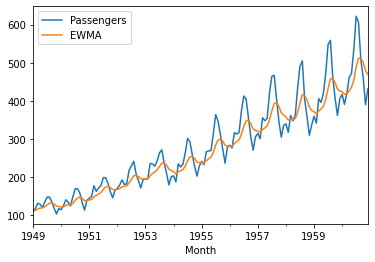

In [8]:
df.plot()

In [9]:
# Manually Calculating the EWMA to ensure Pandas is acting as expected.

manual_ewma = []

for x in df['Passengers'].to_numpy():
    if len(manual_ewma) > 0:
        xhat = alpha * x + (1 - alpha) * manual_ewma[-1]
    else:
        xhat = x    # Copy first value if manual_ewma is empty

    manual_ewma.append(xhat)
df['Manual'] = manual_ewma

df.head()

,Passengers,EWMA,Manual
Month,,,
1949-01-01,112,112.0000,112.0000
1949-02-01,118,113.2000,113.2000
1949-03-01,132,116.9600,116.9600
1949-04-01,129,119.3680,119.3680
1949-05-01,121,119.6944,119.6944


<AxesSubplot:xlabel='Month'>

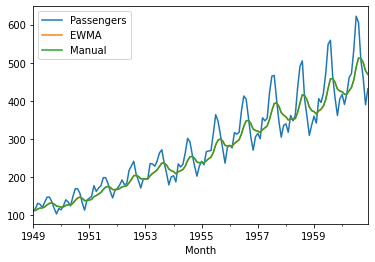

In [10]:
# Appears the manual calculation is the same as the Pandas ewm() function

df.plot()

In [11]:
# Dropping "Manual" column for brevity

df.drop('Manual', axis=1, inplace=True)

---

# Exponential Smoothing (as it relates to **Time Series Forecasting**)

<br/>

## Pseudocode to calculate Exponential Smoothing (via statsmodels)

```py
from statsmodels.tsa.holtwinters import SimpleExpSmoothing

# Make the model - data is univariate
ses = SimpleExpSmoothing(data)  # expecting a 1D array passed to constructor (not fit function)

# 'fit' the model - returns a HoltWintersResults obj
result = ses.fit(smoothing_level=alpha, optimized=False)

# in-sample prediction or out-of-sample forecast
result.predict(start=start_date, end=end_date)
```

<br/>

## Simpler way to predict

```py
# Get all in-sample predictions
result.fittedvalues

# forecast n steps ahead
result.forecast(n)
```


In [12]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing

In [13]:
# Create the model instance

ses = SimpleExpSmoothing(df['Passengers'])

c:\Users\selli\Desktop\Financial Engineering in Python\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
c:\Users\selli\Desktop\Financial Engineering in Python\venv\lib\site-packages\statsmodels\tsa\holtwinters\model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(


In [14]:
# Confirming the warning created above (freq=None)

df.index

DatetimeIndex(['1949-01-01', '1949-02-01', '1949-03-01', '1949-04-01',
               '1949-05-01', '1949-06-01', '1949-07-01', '1949-08-01',
               '1949-09-01', '1949-10-01',
               ...
               '1960-03-01', '1960-04-01', '1960-05-01', '1960-06-01',
               '1960-07-01', '1960-08-01', '1960-09-01', '1960-10-01',
               '1960-11-01', '1960-12-01'],
              dtype='datetime64[ns]', name='Month', length=144, freq=None)

In [15]:
# Assigning frequency to MS (months - see docs)

df.index.freq = 'MS'

In [16]:
# Creating a new instance of model with up-to-date index

ses = SimpleExpSmoothing(df['Passengers'])

In [17]:
# Fit the data to the model

res = ses.fit(smoothing_level=alpha, optimized=False)
res

In [18]:
# Call predict on the results (for the entire data-set, start at 0, end at last)
res.predict(start=df.index[0], end=df.index[-1])

Month
1949-01-01    112.000000
1949-02-01    112.000000
1949-03-01    113.200000
1949-04-01    116.960000
1949-05-01    119.368000
                 ...    
1960-08-01    488.767616
1960-09-01    512.214093
1960-10-01    511.371274
1960-11-01    501.297019
1960-12-01    479.037615
Freq: MS, Length: 144, dtype: float64

In [19]:
# Predicting the values again but assigning them to the original df

df['SES'] = res.predict(start=df.index[0], end=df.index[-1])

<AxesSubplot:xlabel='Month'>

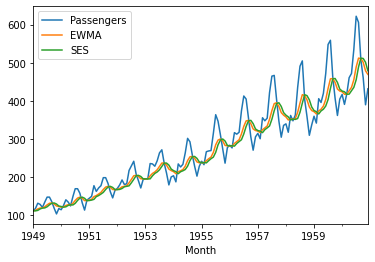

In [20]:
# plot the dataframe

df.plot()

In [21]:
# Checking why the SES seems to be adjusted from EWMA (pandas) by 1

df.head()

,Passengers,EWMA,SES
Month,,,
1949-01-01,112,112.0000,112.000
1949-02-01,118,113.2000,112.000
1949-03-01,132,116.9600,113.200
1949-04-01,129,119.3680,116.960
1949-05-01,121,119.6944,119.368


In [22]:
# Attempting to shift the SES column back by 1 to see if values (EWMA and SES) align

df['SES-1'] = df['SES'].shift(-1)

<AxesSubplot:xlabel='Month'>

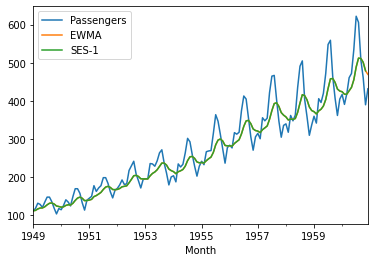

In [23]:
# They do now align - HOWEVER DO NOT DO THIS SHIFTING - A prediction will have to be one step ahead (by definition) especially when intending to use in a Holt-Winters model.

df[['Passengers', 'EWMA', 'SES-1']].plot()

In [24]:
# Split dataset to train/test data (last 12 data points) and make a forecast

N_test = 12
train = df.iloc[:-N_test]
test = df.iloc[-N_test:]

In [25]:
# Re-create the ExpSmoothing obj but only with the Training data 

ses = SimpleExpSmoothing(train['Passengers'])
res = ses.fit()     # Will find the best α for the dataset when nothing is passed

c:\Users\selli\Desktop\Financial Engineering in Python\venv\lib\site-packages\statsmodels\tsa\holtwinters\model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(


<ipython-input-26-4bfeefb01092>:3: FutureWarning: Slicing a positional slice with .loc is not supported, and will raise TypeError in a future version.  Use .loc with labels or .iloc with positions instead.
  df.loc[:-N_test, 'SESfitted'] = res.fittedvalues
<ipython-input-26-4bfeefb01092>:4: FutureWarning: Slicing a positional slice with .loc is not supported, and will raise TypeError in a future version.  Use .loc with labels or .iloc with positions instead.
  df.loc[-N_test:, 'SESfitted'] = res.forecast(N_test)    # N_test amount of time steps


<AxesSubplot:xlabel='Month'>

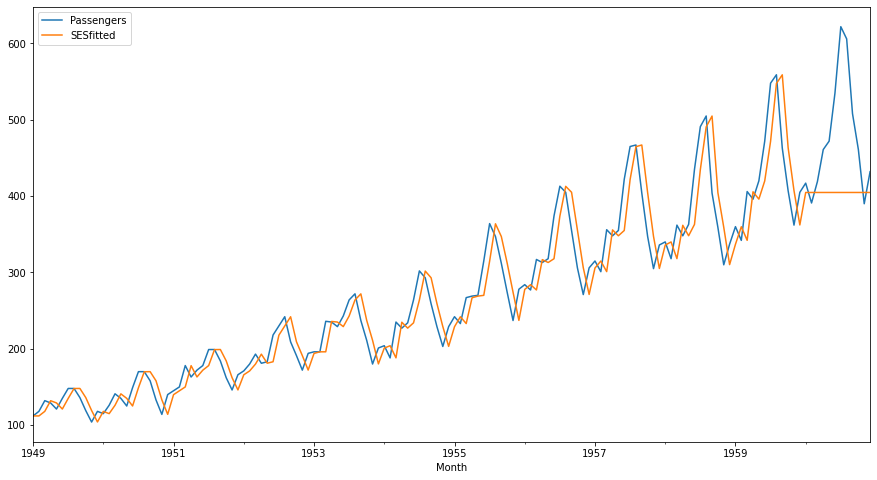

In [26]:
# Assign predictions from model back to original dataframe

df.loc[:-N_test, 'SESfitted'] = res.fittedvalues
df.loc[-N_test:, 'SESfitted'] = res.forecast(N_test)    # N_test amount of time steps

df[['Passengers', 'SESfitted']].plot(figsize=(15,8))

In [27]:
# Checking the value of alpha - expecting to see a number close to 1 since the prediction line is very close to original data line

res.params

{'smoothing_level': 0.995,
 'smoothing_trend': nan,
 'smoothing_seasonal': nan,
 'damping_trend': nan,
 'initial_level': 112.0,
 'initial_trend': nan,
 'initial_seasons': array([], dtype=float64),
 'use_boxcox': False,
 'lamda': None,
 'remove_bias': False}

The 'smoothing_level' is the α.  Being 0.995 means it is basically doing the Naive average (last price continues - ie: horizontal line)

---

# Holt's Linear Trend Model

- With Simple Exponential Smoothing, our forecast was always a straight, horizontal line
- Holt's Linear Trend Model allows for trends (lines at any angle)

A line = y = mx + b

Re-written = y<sub>t</sub> = *slope* * t + y<sub>0</sub>


## Alpha - with regards to Holt's Linear Trend Model
- Normally, Alpha can be a changing value, *tuned* to get you the best fit by your subjective opinion.
- When working with models, we are more able to *fit* alpha, instead of making a guess to the value.

## Holt's Trend Model Code

```py
from statsmodels.tsa.holtwinters import Holt

# Make the model - data is univariate
model - Holt(data)

# 'fit' the model - returns a HoltWintersResults obj
result = model.fit()

# in-sample prediction or out-of-sample forecast
result.fittedvalues
result.forecast(n)
```



In [28]:
from statsmodels.tsa.holtwinters import Holt

In [29]:
# Instantiate the model

holt = Holt(df['Passengers'])

c:\Users\selli\Desktop\Financial Engineering in Python\venv\lib\site-packages\statsmodels\tsa\holtwinters\model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(


In [30]:
# Fit model to data

res_h = holt.fit()

In [31]:
# Assign fitted values to dataframe

df['Holt'] = res_h.fittedvalues

<AxesSubplot:xlabel='Month'>

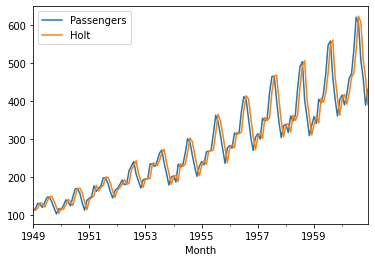

In [32]:
# plot the Holt column and original time series - expecting it to 'track' the original data

df[['Passengers', 'Holt']].plot()

## DO NOT SHIFT THE VALUES!!

In [33]:
# Split the data into training/testing sets and fit the training data

holt = Holt(train['Passengers'])
res_h = holt.fit()
df.loc[:-N_test, 'Holt'] = res_h.fittedvalues

c:\Users\selli\Desktop\Financial Engineering in Python\venv\lib\site-packages\statsmodels\tsa\holtwinters\model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(
<ipython-input-33-2b7be4688149>:5: FutureWarning: Slicing a positional slice with .loc is not supported, and will raise TypeError in a future version.  Use .loc with labels or .iloc with positions instead.
  df.loc[:-N_test, 'Holt'] = res_h.fittedvalues


In [34]:
# Forecast the remaining (empty) rows in the new Holt column on the df and assign

df.loc[-N_test:, 'Holt'] = res_h.forecast(N_test)

<ipython-input-34-e6781ba239fa>:3: FutureWarning: Slicing a positional slice with .loc is not supported, and will raise TypeError in a future version.  Use .loc with labels or .iloc with positions instead.
  df.loc[-N_test:, 'Holt'] = res_h.forecast(N_test)


<AxesSubplot:xlabel='Month'>

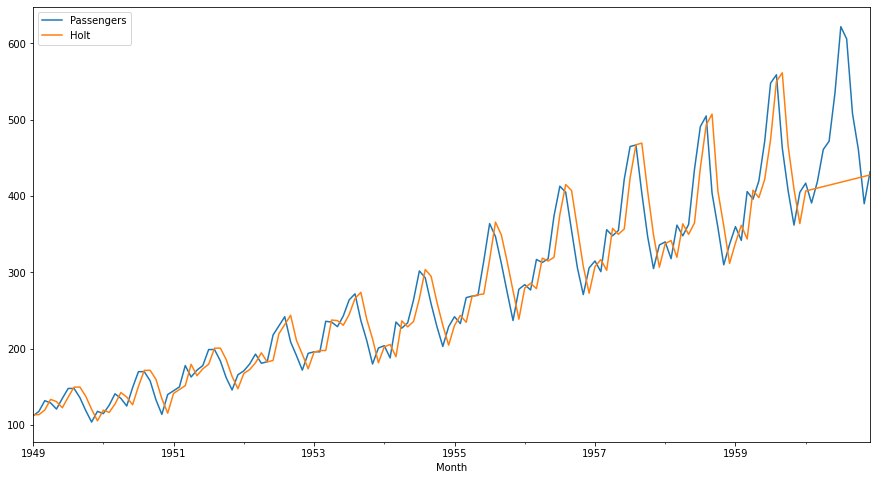

In [35]:
# Plot the in-sample predictions and out-of-sample forecast against original (known) data
# Expecting a up-trend straight line (instead of horizontal line in above excercise)

df[['Passengers', 'Holt']].plot(figsize=(15,8))

---

# Holt-Winters Model

- So far I've learned about:
    - Simple Moving Average
    - Exponentially-Weighted Moving Average
    - Simple Exponential Smoothing as a forecasting model
    - Holt's Linear Trend Model
- **Holt-Winters** adds a seasonal component
    - Applicable everywhere. ie: the weather, air conditioner sales, etc...

## Breakdown

The Holt-Winters Model can be broken down into three parts:
- (Linear) Trend
- Seasonal (cycles)
- Level (average)

### Additive vs. Multiplicative Method

- Additive: y = level + trend + seasonal
- Multiplicative: y = (level + trend) * seasonal

<br/>

## Holt-Winters Model - Code

```py
from statsmodels.tsa.hotwinders import ExponentialSmoothing

# Make the model - data is univariate
# trend/seasonal args can be 'add' or 'mul' (depending on your data)
model = ExponentialSmoothing(data, trend='add', seasonal='add', seasonal_period=12) # 12 periods since using monthly data over years

# 'fit' the model - returns a HoltWintersResults obj
result = model.fit()

# in-sample prediction or out-of-sample forecast
result.fittedvalues
result.forecast(n)

# Then test the error values. You can see if the TEST errors are higher for Multiplicative vs. Additive and use that method for a conclusion.
```

In [36]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [37]:
# Create an instance of the model with the (already split) training data AND seasonality - Then fit the data to the model

hw = ExponentialSmoothing(train['Passengers'], trend='add', seasonal='add', seasonal_periods=12)
res_hw = hw.fit()

c:\Users\selli\Desktop\Financial Engineering in Python\venv\lib\site-packages\statsmodels\tsa\holtwinters\model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(


In [38]:
# Assign training results to dataframe

df.loc[:-N_test, 'HoltWinters'] = res_hw.fittedvalues

<ipython-input-38-bfe4f20ef9d0>:3: FutureWarning: Slicing a positional slice with .loc is not supported, and will raise TypeError in a future version.  Use .loc with labels or .iloc with positions instead.
  df.loc[:-N_test, 'HoltWinters'] = res_hw.fittedvalues


In [39]:
# Assign forecast results to dataframe 

df.loc[-N_test:, 'HoltWinters'] = res_hw.forecast(N_test)

<ipython-input-39-23eb313907f5>:3: FutureWarning: Slicing a positional slice with .loc is not supported, and will raise TypeError in a future version.  Use .loc with labels or .iloc with positions instead.
  df.loc[-N_test:, 'HoltWinters'] = res_hw.forecast(N_test)


In [43]:
import matplotlib.pyplot as plt

Text(0.5, 1.0, 'HoltWinters Additive Model Results\nNote how the model does not need to be shifted and aligns closely to the original data.')

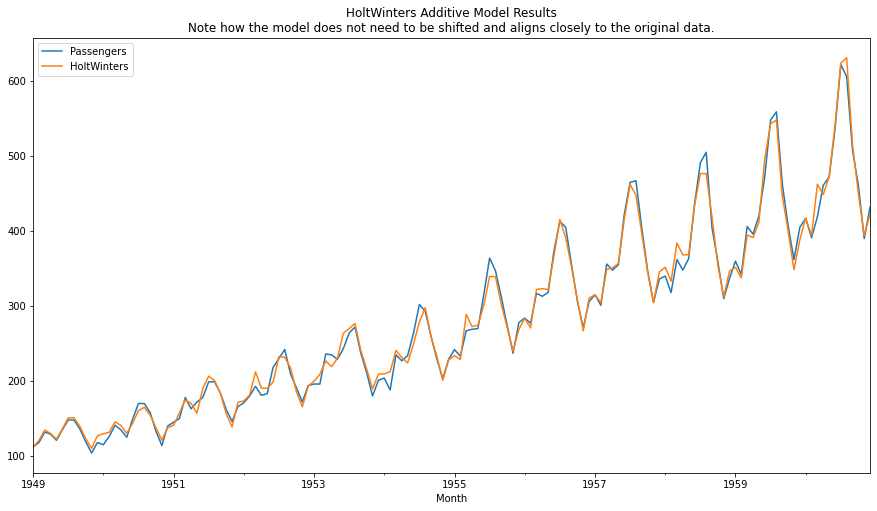

In [57]:
# Plot the original data and the train/test data

df[['Passengers', 'HoltWinters']].plot(figsize=(15,8))
plt.title("HoltWinters Additive Model Results\nNote how the model does not need to be shifted and aligns closely to the original data.")

In [52]:
# Calculate the Root Mean Squared Error (RMSE)

def rmse(t, y):
    return np.sqrt(np.mean((y-t) ** 2))

In [47]:
# Calculate the Mean Absolute Error (MAE)

def mae(y, t):
    return np.mean(np.abs(y-t))

In [53]:
print("Train RMSE:", rmse(train['Passengers'], res_hw.fittedvalues))
print("Test RMSE:", rmse(test['Passengers'], res_hw.forecast(N_test)))

Train RMSE: 11.624714430673352
Test RMSE: 16.978029847029934


In [49]:
print("Train MAE:", mae(train['Passengers'], res_hw.fittedvalues))
print("Test MAE:", mae(test['Passengers'], res_hw.forecast(N_test)))

Train MAE: 9.006650631052384
Test MAE: 13.37759090303536


c:\Users\selli\Desktop\Financial Engineering in Python\venv\lib\site-packages\statsmodels\tsa\holtwinters\model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(
<ipython-input-62-ce40f39feee3>:6: FutureWarning: Slicing a positional slice with .loc is not supported, and will raise TypeError in a future version.  Use .loc with labels or .iloc with positions instead.
  df.loc[:-N_test, 'HoltWinters'] = res_hw.fittedvalues
<ipython-input-62-ce40f39feee3>:7: FutureWarning: Slicing a positional slice with .loc is not supported, and will raise TypeError in a future version.  Use .loc with labels or .iloc with positions instead.
  df.loc[-N_test:, 'HoltWinters'] = res_hw.forecast(N_test)


<AxesSubplot:title={'center':'HoltWinters Multiplicative Seasonality, Additive Trend Model - Results\n\nTo me, this version seems to fit even better to the original dataset.\nTesting the accuracy (as above) would confirm.'}, xlabel='Month'>

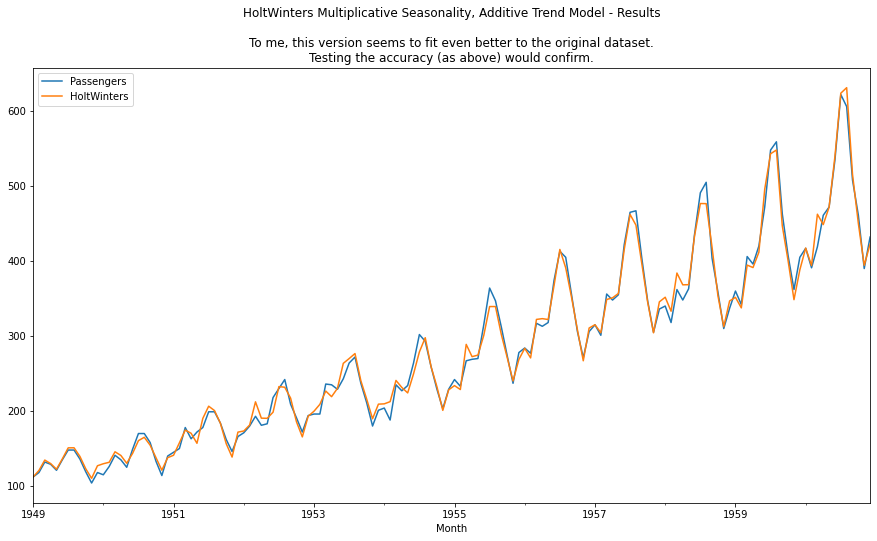

In [62]:
# Doing the same thing but with additive trend and multiplicable seasonality model

hw = ExponentialSmoothing(train['Passengers'], \
                          trend='add', seasonal='mul', seasonal_periods=12)
res_hw = hw.fit()
df.loc[:-N_test, 'HoltWinters'] = res_hw.fittedvalues
df.loc[-N_test:, 'HoltWinters'] = res_hw.forecast(N_test)
df[['Passengers', 'HoltWinters']].plot(figsize=(15,8), title="HoltWinters Multiplicative Seasonality, Additive Trend Model - Results\n\nTo me, this version seems to fit even better to the original dataset.\nTesting the accuracy (as above) would confirm.")

In [59]:
print("Train RMSE:", rmse(train['Passengers'], res_hw.fittedvalues))
print("Test RMSE:", rmse(test['Passengers'], res_hw.forecast(N_test)))

Train RMSE: 9.767995205168011
Test RMSE: 15.810870232569963


In [60]:
print("Train MAE:", mae(train['Passengers'], res_hw.fittedvalues))
print("Test MAE:", mae(test['Passengers'], res_hw.forecast(N_test)))

Train MAE: 7.604272329965027
Test MAE: 10.30368288348438


Indeed it does seem that the errors are less when using this *multiplicative model* than the *additive model*.

c:\Users\selli\Desktop\Financial Engineering in Python\venv\lib\site-packages\statsmodels\tsa\holtwinters\model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(
c:\Users\selli\Desktop\Financial Engineering in Python\venv\lib\site-packages\statsmodels\tsa\holtwinters\model.py:80: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
<ipython-input-68-2e45371c90c2>:6: FutureWarning: Slicing a positional slice with .loc is not supported, and will raise TypeError in a future version.  Use .loc with labels or .iloc with positions instead.
  df.loc[:-N_test, 'HoltWinters'] = res_hw.fittedvalues
<ipython-input-68-2e45371c90c2>:7: FutureWarning: Slicing a positional slice with .loc is not supported, and will raise TypeError in a future version.  Use .loc with labels or .iloc with positions instead.
  df.loc[-N_test:, 'HoltWinters'] = res_hw.forecast(N_test)


<AxesSubplot:title={'center':'HoltWinters Multiplicative Seasonality & Trend Model - Results\n\nTests show the model (using multiplicative for trend and seasonality) overfits the testing data.\nThe training data shows way too high an error to be used.'}, xlabel='Month'>

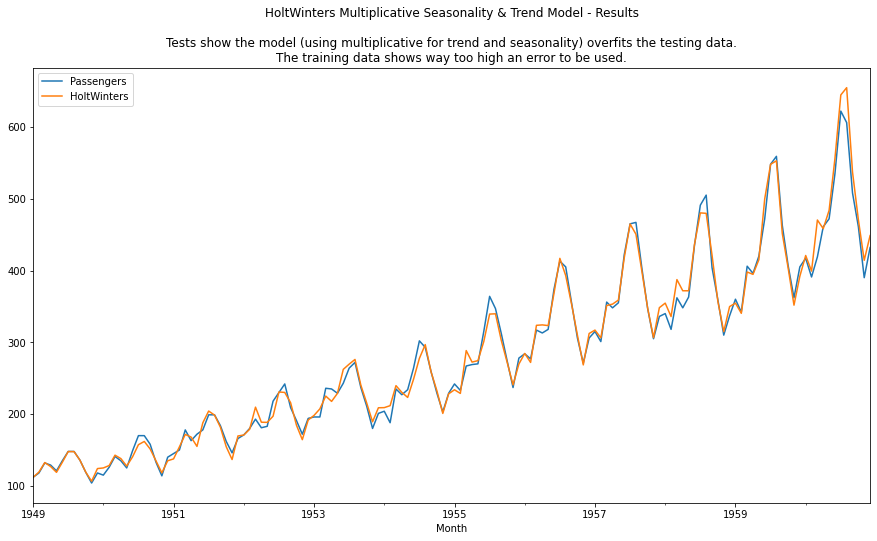

In [68]:
# Doing the same thing but with multiplicable trend and seasonality model

hw = ExponentialSmoothing(train['Passengers'], \
                          trend='mul', seasonal='mul', seasonal_periods=12)
res_hw = hw.fit()
df.loc[:-N_test, 'HoltWinters'] = res_hw.fittedvalues
df.loc[-N_test:, 'HoltWinters'] = res_hw.forecast(N_test)
df[['Passengers', 'HoltWinters']].plot(figsize=(15,8), title="HoltWinters Multiplicative Seasonality & Trend Model - Results\n\nTests show the model (using multiplicative for trend and seasonality) overfits the testing data.\nThe training data shows way too high an error to be used.")

In [65]:
print("Train RMSE:", rmse(train['Passengers'], res_hw.fittedvalues))
print("Test RMSE:", rmse(test['Passengers'], res_hw.forecast(N_test)))

Train RMSE: 9.61792487803932
Test RMSE: 25.80687515735493


In [66]:
print("Train MAE:", mae(train['Passengers'], res_hw.fittedvalues))
print("Test MAE:", mae(test['Passengers'], res_hw.forecast(N_test)))

Train MAE: 7.112379992634933
Test MAE: 20.844988412204554
